In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Dataset
df = pd.read_csv('/content/drive/MyDrive/Coursework/South_Asian_dataset new.csv')

In [ ]:
# Display basic information
print("Dataset Overview:\n", df.info())
print("\nSummary Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())
print("\nColumn Names:\n", df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 10 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Country                                                              192 non-null    object 
 1   Year                                                                 192 non-null    int64  
 2   GDP (current US$)                                                    192 non-null    object 
 3   GDP growth (annual %)                                                192 non-null    object 
 4   GDP per capita (current US$)                                         192 non-null    object 
 5   Unemployment, total (% of total labor force) (modeled ILO estimate)  192 non-null    float64
 6   Population, total                                                    192 non-null    int64  
 7   Populati

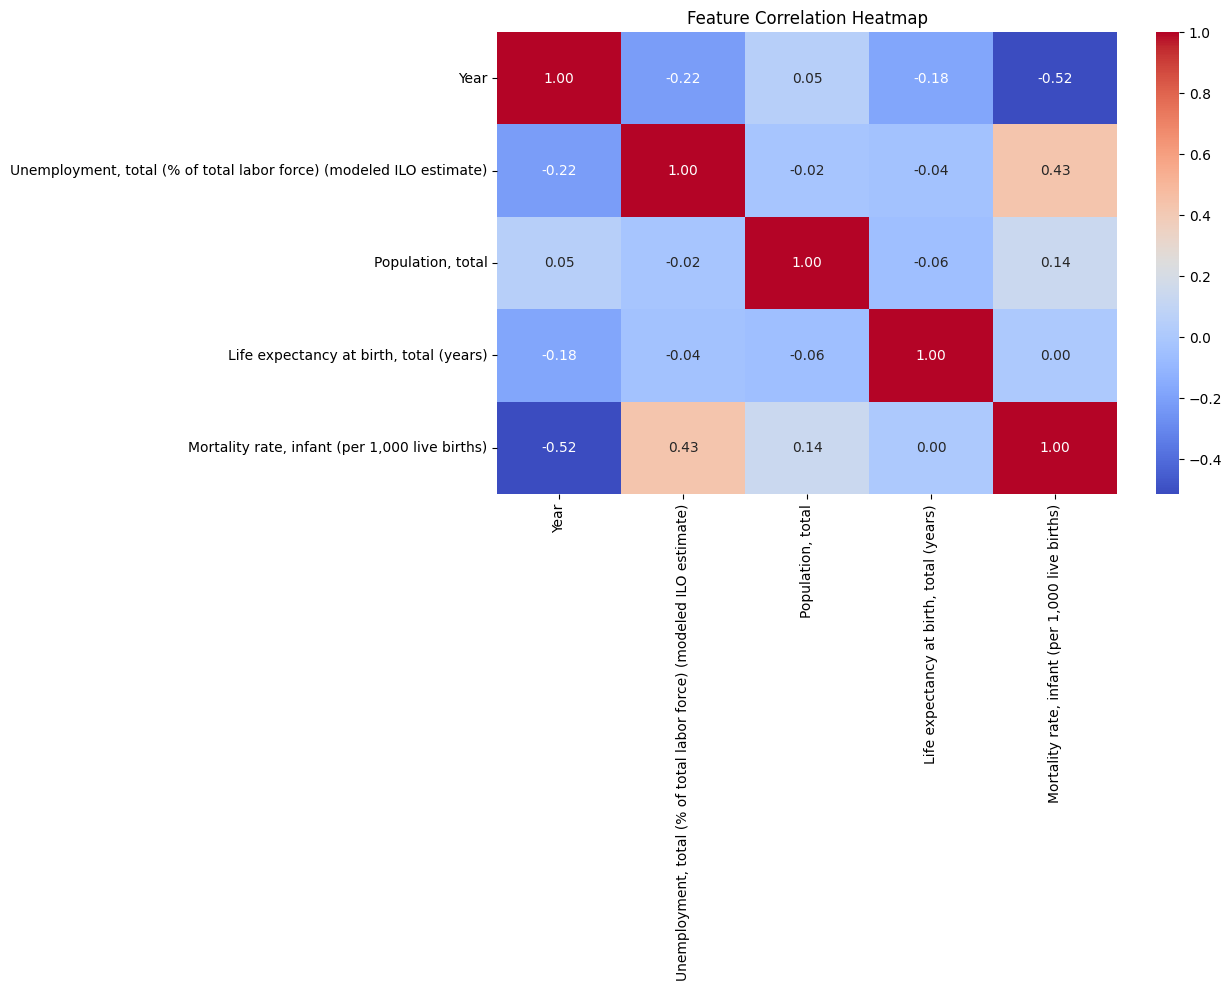

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
# Select only numerical features for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

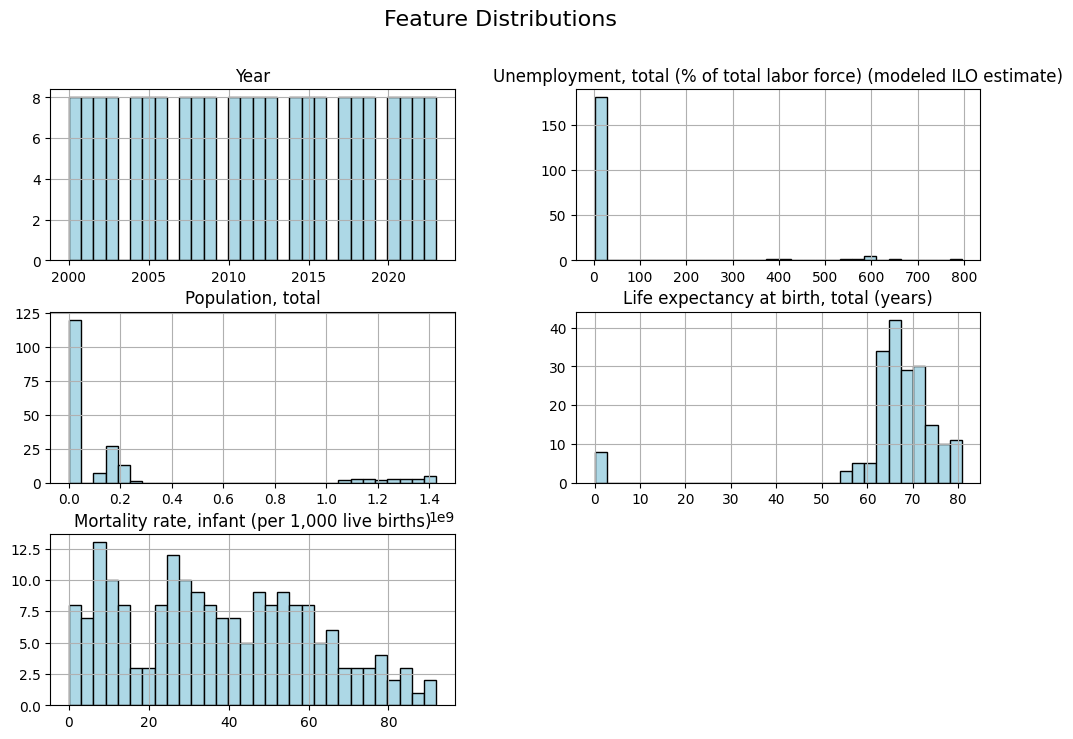

In [ ]:
# Feature Distributions
df.hist(figsize=(12, 8), bins=30, color='lightblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

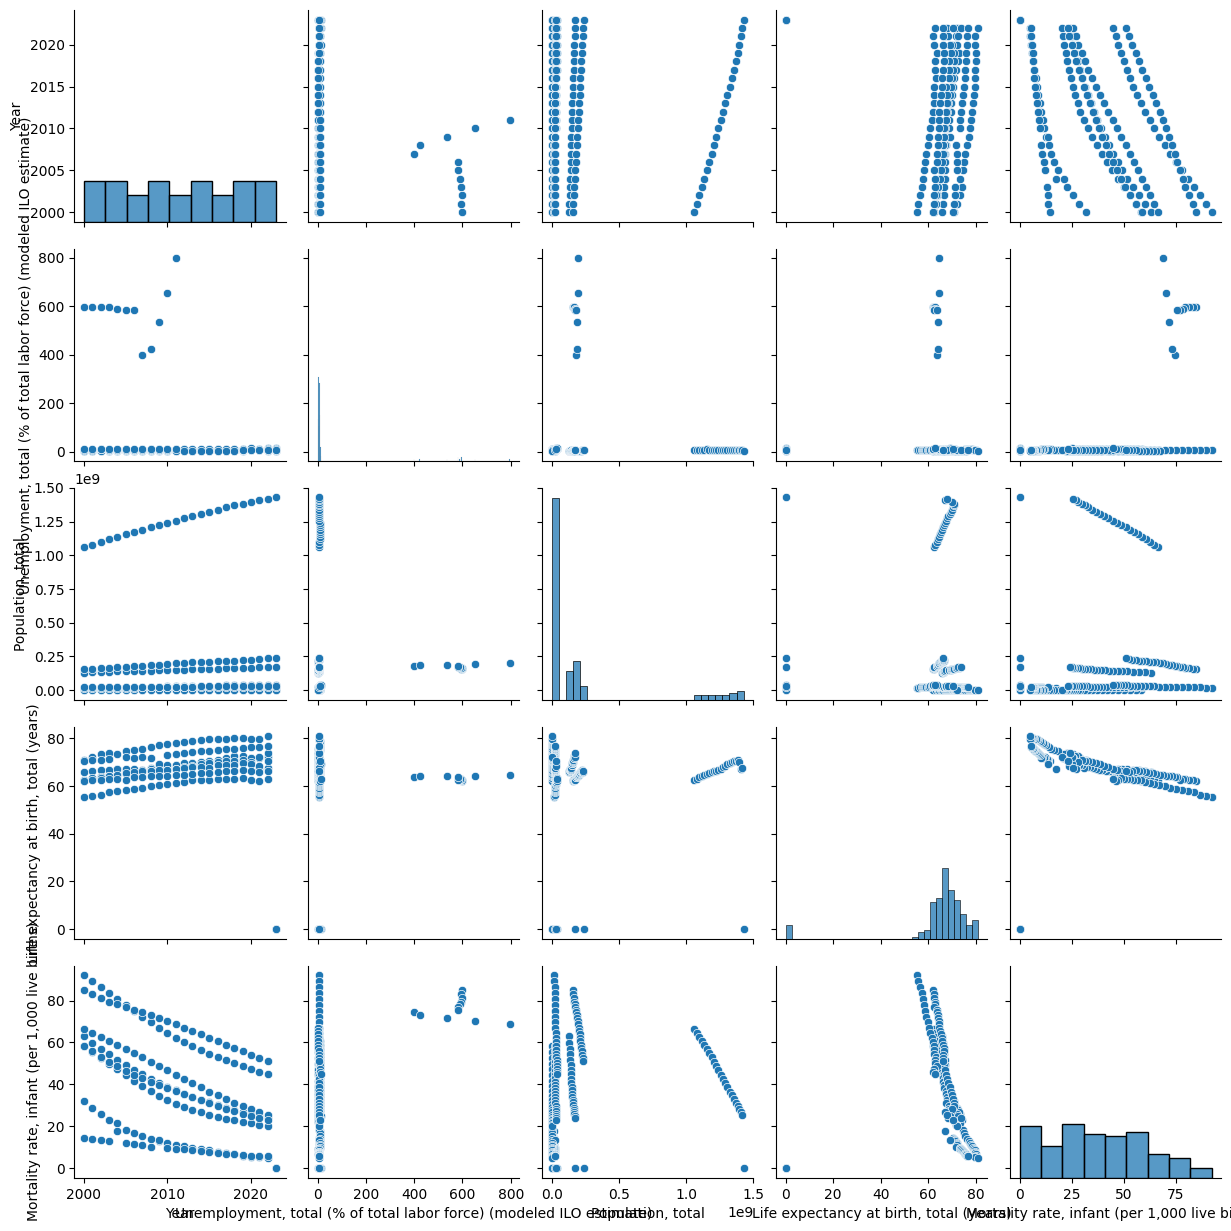

In [ ]:

# Pairplot to explore relationships (Only for small datasets)
sns.pairplot(df)
plt.show()

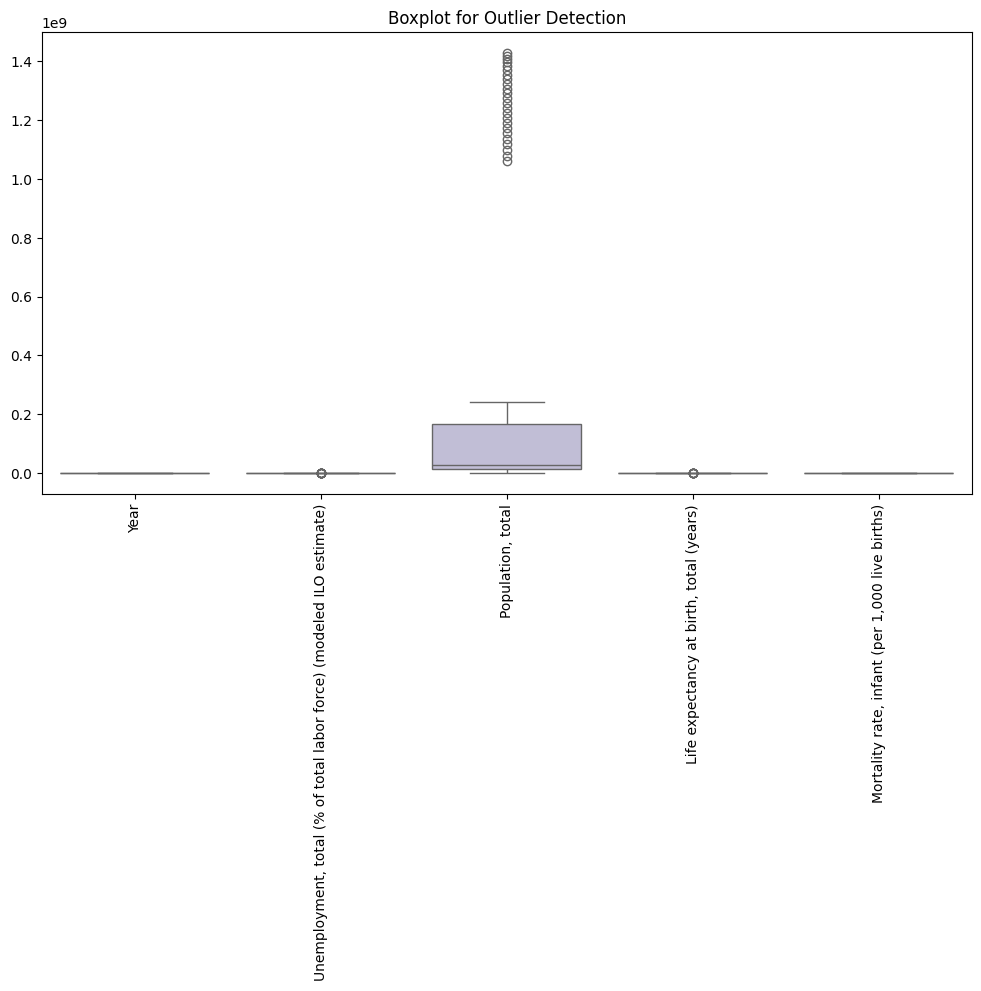

In [ ]:
# Boxplots for Outlier Detection
plt.figure(figsize=(12,6))
sns.boxplot(data=df, palette="Set3")
plt.xticks(rotation=90)
plt.title("Boxplot for Outlier Detection")
plt.show()

In [ ]:
# Choosing an appropriate target column
target_column = 'Unemployment, total (% of total labor force) (modeled ILO estimate)'

In [ ]:
#Data Preprocessing
# Handle missing values
df.dropna(inplace=True)

In [ ]:
# Convert categorical columns to numeric if necessary
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# Splitting dataset into features and target variable
X = df.drop(columns=[target_column])
y = df[target_column]

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Standardize target variable
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


In [ ]:
# Build Linear Regression from Scratch
def linear_regression(X, y, alpha=0.01, iterations=1000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(iterations):
        predictions = X @ theta
        errors = predictions - y
        theta -= (alpha/m) * (X.T @ errors)
    return theta

X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
theta = linear_regression(X_train_bias, y_train)

def predict(X, theta):
    return X @ theta

y_pred_custom = predict(np.c_[np.ones((X_test.shape[0], 1)), X_test], theta)
print("Custom Linear Regression Performance:")
print("MSE:", mean_squared_error(y_test, y_pred_custom))
print("R2 Score:", r2_score(y_test, y_pred_custom))

Custom Linear Regression Performance:
MSE: 0.38097443494139843
R2 Score: 0.012085417082965066


In [ ]:
# Train ML Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor()
}

model_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[name] = {"MSE": mse, "R2 Score": r2}
    print(f"\n{name} Performance:")
    print("MSE:", mse)
    print("R2 Score:", r2)


Linear Regression Performance:
MSE: 0.38213450949452044
R2 Score: 0.009077197992157893

Ridge Regression Performance:
MSE: 0.37983329083670786
R2 Score: 0.015044547142196052

Lasso Regression Performance:
MSE: 0.4153453698923658
R2 Score: -0.07704273628453451

Decision Tree Performance:
MSE: 3.099106902785439e-05
R2 Score: 0.9999196362636839

Random Forest Performance:
MSE: 0.0034957279653342922
R2 Score: 0.9909351381139371


In [ ]:
# Hyperparameter Optimization using GridSearchCV
param_grid = {
    'Ridge Regression': {'alpha': [0.1, 1, 10]},
    'Lasso Regression': {'alpha': [0.1, 1, 10]},
    'Decision Tree': {'max_depth': [3, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200]}
}

best_models = {}
for name, model in models.items():
    if name in param_grid:
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        print(f"\nBest parameters for {name}: {grid_search.best_params_}")


Best parameters for Ridge Regression: {'alpha': 1}

Best parameters for Lasso Regression: {'alpha': 0.1}

Best parameters for Decision Tree: {'max_depth': 5}

Best parameters for Random Forest: {'n_estimators': 50}


In [ ]:
# Feature Selection using Recursive Feature Elimination (RFE)
rfe = RFE(LinearRegression(), n_features_to_select=5)
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]
print("\nSelected Features:", selected_features)


Selected Features: Index(['Country', 'GDP (current US$)', 'GDP per capita (current US$)',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)'],
      dtype='object')


In [ ]:
# Final Model Evaluation
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[name] = {"MSE": mse, "R2 Score": r2}
    print(f"\nFinal {name} Model Performance:")
    print("MSE:", mse)
    print("R2 Score:", r2)


Final Ridge Regression Model Performance:
MSE: 0.37983329083670786
R2 Score: 0.015044547142196052

Final Lasso Regression Model Performance:
MSE: 0.3306751184304728
R2 Score: 0.14251786539028144

Final Decision Tree Model Performance:
MSE: 0.00022532108031689062
R2 Score: 0.9994157141249703

Final Random Forest Model Performance:
MSE: 0.017879312506486646
R2 Score: 0.9536366959625361


In [ ]:
# Conclusion
print("\nConclusion: Model Performance Summary")
for name, results in model_results.items():
    print(f"{name}: MSE = {results['MSE']}, R2 Score = {results['R2 Score']}")

best_model = max(best_models, key=lambda name: model_results[name]["R2 Score"])
print(f"\nThe best performing model based on R2 Score is: {best_model}")


Conclusion: Model Performance Summary
Linear Regression: MSE = 0.38213450949452044, R2 Score = 0.009077197992157893
Ridge Regression: MSE = 0.37983329083670786, R2 Score = 0.015044547142196052
Lasso Regression: MSE = 0.3306751184304728, R2 Score = 0.14251786539028144
Decision Tree: MSE = 0.00022532108031689062, R2 Score = 0.9994157141249703
Random Forest: MSE = 0.017879312506486646, R2 Score = 0.9536366959625361

The best performing model based on R2 Score is: Decision Tree
